# Python 例3: 使用PyTorch求解RTE(和Matlab代码对比)


```matlab
% it solves the multiscale heat transfer based on the phonon Boltzmann transport equation
% by using the synthetic iteration scheme
% the BTE are given by Phys. Rev. E 96 (2017) 063311, but the macroscopic
% acceleration equation is different. In fact, our macroscopic equation is
% derived exactly from the BTE

% Initial condition
a = 1;
c = 1;
rho = 1;
cv = 1;

fileIDI0 = fopen('I0.txt', 'w');
fileIDT = fopen('T.txt','w');
% ini = sin(2 * pi * x)

% spatial grid
N=400;
L = 1;
dx = L / N;
x = 0.5 * dx : dx : L - 0.5 * dx;
Tini = 0.1 * sin(2 * pi * x) + 1;
sigma = 1; 
CFL = 0.8;
dt=CFL*dx; % time step
dtc = dt * c;
ddtc = 1/ dtc;

% velocity grid & angle
Nvx=8;
[mu, wmu] = Get_Gauss_Point(Nvx);

% distribution function

T = Tini;
I = zeros(Nvx, N + 2);
I(:, 2:end-1) = repmat(0.5 * a * c * Tini.^4, Nvx, 1);
I(:,1)=I(:, end-1); I(:,end)=I(:,2); % boundary condition

I0 =  wmu' * I; % energe

%% main iteration

for loop=1: 1/dt
    I_out = I;
    T_out = T;
    I0_out = I0;

    %% streaming, positive vx
    lv=Nvx/2+1:Nvx;coe = mu(lv); index = 2:N + 1;
    I(lv, index) = I_out(lv, index) ...
        - dt / dx * coe .* (I_out(lv, index) - I_out(lv, index -1))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2, 1) - I_out(lv, index));

    %% streaming, negative vx
    lv=1:Nvx/2; coe= mu(lv);
    I(lv,index)= I_out(lv, index) ...
        -dt / dx * coe .* (I_out(lv, index+1) - I_out(lv, index))...
        +  dt * sigma * (0.5*a*c * repmat(T_out.^4, Nvx/2,1) - I_out(lv, index));

    %% macroscopic quantities

    I(:,end)= I(:, 2); I(:,1)= I(:, end-1);

    T = T_out + dt / cv * sigma .* (I0_out(index) - a  * c * T_out.^4);
    I0 =  wmu' * I;

    loop
    fprintf(fileIDI0, '%12.8f',I0(2:end-1));
    fprintf(fileIDT, '%12.8f',T);
    fprintf(fileIDT, '\n');
    fprintf(fileIDI0, '\n');
end
fclose(fileIDI0);
fclose(fileIDT);


function [points, weight] = Get_Gauss_Point(n)
syms x 

f = legendreP(n, x);
points = sort(double(solve(f==0)));
tmpf = diff(f, x); 
tmpf = subs(tmpf, 'x', points); 
weight = double(2 ./ (1 - points.^2) ./ (tmpf.^2));

end
```

## 导入用到的包

In [18]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 辅助函数 get_gauss_point

在matlab中，我们使用

```matlab
function [points, weight] = Get_Gauss_Point(n)
syms x 

f = legendreP(n, x);
points = sort(double(solve(f==0)));
tmpf = diff(f, x); 
tmpf = subs(tmpf, 'x', points); 
weight = double(2 ./ (1 - points.^2) ./ (tmpf.^2));

end
```

获取积分节点和权重

In [19]:
def get_gauss_point(n):
    x, w = np.polynomial.legendre.leggauss(n)
    return torch.from_numpy(x).to(dtype=torch.get_default_dtype()), torch.from_numpy(w).to(dtype=torch.get_default_dtype())

## 定义问题参数
```
% Initial condition
a = 1;
c = 1;
rho = 1;
cv = 1;
```

In [22]:
a = 1
c = 1
rho = 1
cv = 1

## 定义空间网格，设定初值


```matlab
N=400;
L = 1;
dx = L / N;
x = 0.5 * dx : dx : L - 0.5 * dx;
Tini = 0.1 * sin(2 * pi * x) + 1;
sigma = 1; 
CFL = 0.8;
dt=CFL*dx; % time step
dtc = dt * c;
ddtc = 1/ dtc;
```

下面是对应的Python代码

In [27]:
# spatial grid
N = 400
L = 1
dx = L / N
x = torch.arange(0.5 * dx, L + 0.5 * dx, dx)

Tini =  1 + 0.1 * torch.sin(2 * np.pi * x)
sigma = 1 + 0.1 * torch.sin(2 * np.pi * x)

CFL = 0.8
dt = CFL * dx  # time step
dtc = dt * c
ddtc = 1 / dtc

In [28]:

datarecord_sigma=sigma.clone()[None,:]

# velocity grid & angle
Nvx = 8
mu, wmu = get_gauss_point(Nvx)

# distribution function
T = Tini
I = 0.5 * a * c * Tini**4
I = I.repeat(Nvx, 1)
I = F.pad(I[None, ...], (1, 1), mode='circular')[0]

Flux=torch.zeros((Nvx,N+1))
I0 = wmu @ I  # energe
sigma = sigma.repeat(Nvx // 2, 1)

t=1.0
Nt=int(t / dt)
list_T=[]
list_E=[]
list_M=[]
list_u=[]
for loop in range(Nt):  #=1: 1/dt
    I_out = I.clone()
    T_out = T.clone()
    I0_out = I0.clone()

    index = slice(1, -1)
    index_add1 = slice(2, None)
    index_sub1 = slice(None, -2)

    # streaming, positive vx
    lv = slice(Nvx // 2, None)
    coe = mu[lv]
    I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
        I_out[lv, index] - I_out[lv, index_sub1]) + dt * sigma * (
            (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])

    # streaming, negative vx
    lv = slice(0, Nvx // 2)
    coe = mu[lv]
    I[lv, index] = I_out[lv, index] - dt / dx * coe[..., None] * (
        I_out[lv, index_add1] - I_out[lv, index]) + dt * sigma * (
            (0.5 * a * c * T_out**4).repeat(Nvx // 2, 1) - I_out[lv, index])

    I = F.pad(I[None, ..., 1:-1], (1, 1), mode='circular')[0]
    T = T_out + dt / cv * sigma[0, :] * (I0_out[index] - a * c * T_out**4)
    I0 = wmu @ I

    if loop%10==0:
        list_E.append(I0[...,1:-1].clone())
        list_T.append(T.clone())
    print(loop)
datarecord_E=torch.stack(list_E,dim=0)
datarecord_T=torch.stack(list_T,dim=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

SyntaxError: 'return' outside function (1732988459.py, line 56)

In [10]:
datarecord_E,datarecord_T,datarecord_sigma=functorch.vmap(gendata,randomness='different')(torch.arange(0,100))
datarecord_E.shape

torch.save({
    "E":datarecord_E,
    "T":datarecord_T,
    "M":datarecord_M,
    "sigma":datarecord_sigma,
    "u":datarecord_u
},"full.pt")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: too many values to unpack (expected 3)

In [11]:
datarecord_E.shape

torch.Size([100, 50, 400])

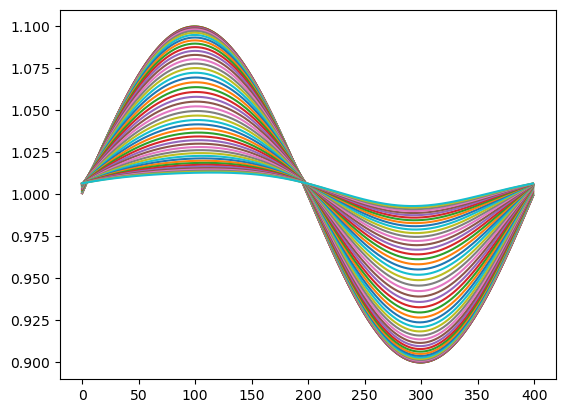

In [14]:
plt.plot(datarecord_T[0].T)